In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import BeliefDistributionSetup as bds
from sklearn import preprocessing
import earth_movers_distance as emd
import matplotlib.pylab as pl
import matplotlib.patches as patches
%matplotlib inline

In [2]:
df = pd.read_csv("Patient_Medical_History.csv") 

In [3]:
# this is a list of the column names in our dataset 
names = (
    'id',
    'gender',
    'age',
    'dob',
    'zipcode',
    'employment_status',
    'education',
    'marital_status',
    'children,ancestry',
    'avg_commute',
    'daily_internet_use',
    'available_vehicles',
    'military_service',
    'disease'
)

# some fields are categorical and will require special treatment
categorical = set((
    'id',
    'gender',
    'employment_status',
    'education',
    'marital_status',
    'ancestry',
    'military_service',
    'disease',
    'dob'
))

In [4]:
df

,id,gender,age,dob,zipcode,employment_status,education,marital_status,children,ancestry,avg_commute,daily_internet_use,available_vehicles,military_service,disease
0,Amelia Nixon,female,50,3/9/1944,89136,retired,bachelors,married,1,Portugal,13.38,2.53,2,no,hypertension
1,Clara Hicks,female,38,7/2/1966,94105,employed,phd/md,married,4,Sweden,15.16,6.77,2,no,endometriosis
2,Mason Brown,male,53,5/31/1981,89127,employed,masters,married,2,Germany,23.60,3.63,1,no,prostate cancer
3,Michael Rice,male,28,2/13/1945,44101,retired,bachelors,married,2,Denmark,19.61,5.00,3,no,multiple sclerosis
4,Eleanor Ritter,female,37,9/3/1939,89136,retired,masters,married,3,Austria,36.55,7.75,1,no,skin cancer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Ethan Johnson,male,49,4/13/1942,89127,retired,masters,married,1,Switzerland,28.48,5.88,1,no,heart disease
1996,Natalia Dominguez,female,75,5/10/1963,60612,unemployed,highschool,married,4,Denmark,21.09,5.92,0,no,gastritis
1997,Joseph Zuniga,male,33,7/12/1965,94110,employed,bachelors,married,2,Russia,30.80,4.91,2,no,hypertension
1998,Daniel Murphy,male,22,8/10/1926,90015,retired,bachelors,married,3,Finland,37.56,2.69,0,no,prostate cancer


From all these initial steps for understanding of data, we can see the data is clean and free from null values, outliers and duplicates
Let's start partitioning for K-anonymity further. 

In [5]:
for name in categorical:
    df[name] = df[name].astype('category')


def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df.loc[partition,column].max()-df.loc[partition,column].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [6]:
full_spans = get_spans(df,df.index)
full_spans

{'id': 2000,
 'gender': 2,
 'age': 73,
 'dob': 1877,
 'zipcode': 84109,
 'employment_status': 4,
 'education': 6,
 'marital_status': 2,
 'children': 7,
 'ancestry': 20,
 'avg_commute': 66.2,
 'daily_internet_use': 7.8100000000000005,
 'available_vehicles': 4,
 'military_service': 2,
 'disease': 13}

In [7]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)
 

In [8]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions

In [9]:
# we apply our partitioning method to two columns of our dataset, using "disease" as the sensitive attribute
feature_columns = ['age', 'daily_internet_use']
sensitive_column = 'disease'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)
print(len(finished_partitions))

515


Let's visualize the created partitions! To do that, we will write functions to get the rectangular bounds of a partition along two columns. We can then plot these rects to see how our partitioning function divides the dataset. If we perform the partition only along the two columns selected for plotting then the resulting rects should not overlap and cover the entire dataset.

In [10]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

Generating an k-Anonymous Dataset

In [11]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [12]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [13]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...
Finished 301 partitions...
Finished 401 partitions...
Finished 501 partitions...


In [14]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,age,daily_internet_use,disease,count
298,17.0,4.133333,Alzheimer's disease,1
299,17.0,4.133333,hypertension,1
300,17.0,4.133333,kidney disease,1
485,17.0,5.683333,breast cancer,1
486,17.0,5.683333,heart disease,1
...,...,...,...,...
1662,80.0,4.460000,kidney disease,1
1497,82.8,6.908000,Alzheimer's disease,1
1498,82.8,6.908000,breast cancer,1
1499,82.8,6.908000,hypertension,2


In [15]:
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
dfn['disease']= label_encoder.fit_transform(dfn['disease'])
 
dfn['disease'].unique()

array([ 0,  3,  8, 10, 12,  7, 11,  4,  2,  9,  6,  5,  1])

In [16]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
dfn['disease']= label_encoder.fit_transform(dfn['disease'])


In [17]:
dfn.to_csv('proposedKanonymity_result1.csv',index=False)

In [18]:
k_t = emd.EMD_ordered_distance("proposedKanonymity_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(k_t)


unique worked
0.5876293692638157


In [19]:
k_d = emd.divergence("proposedKanonymity_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(k_d)

unique worked
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [20]:
k_h=emd.hellinger("proposedKanonymity_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(k_h)

unique worked
0.2759655786249855


In [21]:
k_kl=emd.klDivergence("proposedKanonymity_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(k_kl)

unique worked
0


# Implementing t-closeness

In [22]:
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [23]:
global_freqs


{"Alzheimer's disease": 0.1695,
 'HIV/AIDS': 0.04,
 'breast cancer': 0.0725,
 'diabetes': 0.0595,
 'endometriosis': 0.033,
 'gastritis': 0.05,
 'heart disease': 0.0435,
 'hypertension': 0.149,
 'kidney disease': 0.0925,
 'multiple sclerosis': 0.0565,
 'prostate cancer': 0.09,
 'schizophrenia': 0.0275,
 'skin cancer': 0.1165}

In [24]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.2):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [25]:
# Let's apply this to our dataset
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [26]:
len(finished_t_close_partitions)

184

In [27]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...


In [28]:
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dft.sort_values(feature_columns+[sensitive_column])

,age,daily_internet_use,disease,count
575,17.200000,3.434,diabetes,1
576,17.200000,3.434,endometriosis,1
577,17.200000,3.434,hypertension,1
578,17.200000,3.434,schizophrenia,1
579,17.200000,3.434,skin cancer,1
...,...,...,...,...
1014,76.222222,3.490,hypertension,2
1015,76.222222,3.490,kidney disease,2
1016,76.222222,3.490,multiple sclerosis,1
1017,76.222222,3.490,prostate cancer,1


In [29]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
dft['disease']= label_encoder.fit_transform(dft['disease'])
 
dft['disease'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11,  4, 12,  9])

In [30]:
dft.to_csv('proposedTcloseness_result1.csv',index=False)

In [31]:
t_t = emd.EMD_ordered_distance("proposedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(t_t)



unique worked
0.578095621810368


In [32]:
t_h=emd.hellinger("proposedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(t_h)

unique worked
0.24253562503633297


Divergence

In [33]:
t_d = emd.divergence("proposedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(t_d)

unique worked
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0


In [34]:
t_kl=emd.klDivergence("proposedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(t_kl)

unique worked
0


In [35]:
print("No of K partitions",len(finished_partitions))
print("No of T partitions",len(finished_t_close_partitions))

No of K partitions 515
No of T partitions 184


# Implementing t-closeness 2

In [36]:
dfnew= pd.read_csv('proposedTcloseness_result1.csv')

In [37]:
df=dfnew.copy()
# here we generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [51]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = dfnew.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=0.1):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [52]:
# Let's apply this to our dataset
finished_improved_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [53]:
len(finished_improved_t_close_partitions)

96

In [54]:
dftnew = build_anonymized_dataset(df, finished_improved_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [55]:
# Let's see how t-closeness fares
dftnew.sort_values (feature_columns + [sensitive_column])

,age,daily_internet_use,disease,count
530,17.750000,5.729167,1,1
531,17.750000,5.729167,2,1
532,17.750000,5.729167,3,1
533,17.750000,5.729167,5,1
534,17.750000,5.729167,6,1
...,...,...,...,...
866,76.222222,3.490000,7,1
867,76.222222,3.490000,8,1
868,76.222222,3.490000,9,1
869,76.222222,3.490000,10,1


In [56]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
dft['disease']= label_encoder.fit_transform(dft['disease'])
 
dft['disease'].unique()

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11,  4, 12,  9], dtype=int64)

In [57]:
dft.to_csv('improvedTcloseness_result1.csv',index=False)

In [58]:
IT_t = emd.EMD_ordered_distance("improvedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(IT_t)
IT_h=emd.hellinger("improvedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(IT_h)
IT_d = emd.divergence("improvedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(IT_d)
IT_kl=emd.klDivergence("improvedTcloseness_result1.csv", ['age', 'daily_internet_use'], ['disease'])
print(IT_kl)

unique worked
0.578095621810368
unique worked
0.24253562503633297
unique worked
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
unique worked
0


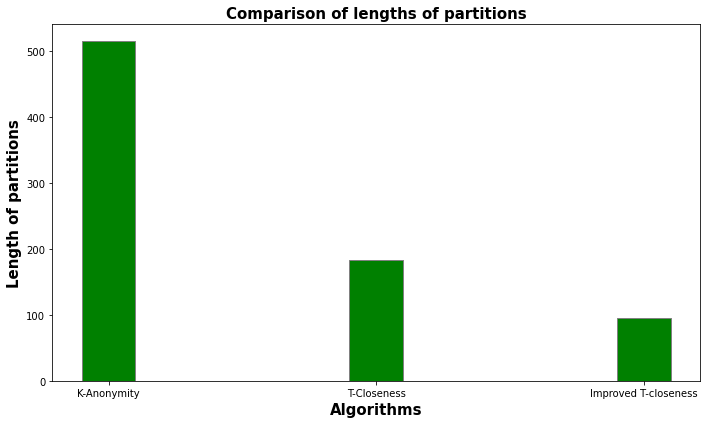

In [59]:
labels = ['K-Anonymity',  'T-Closeness','Improved T-closeness']
x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize =(10, 6))

# set height of bar
lengths=[len(finished_partitions),len(finished_t_close_partitions),len(finished_improved_t_close_partitions)]

 # Set position of bar on X axis
br1 = np.arange(len(T))
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
# Make the plot

plt.bar(br1,lengths,color ='g', width = width,
        edgecolor ='grey', label ='T')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Length of partitions',fontsize = 15,fontweight ='bold')
ax.set_title('Comparison of lengths of partitions',fontweight ='bold', fontsize = 15)

ax.set_xticks(x)
ax.set_xticklabels(labels)

fig.tight_layout()

plt.show()

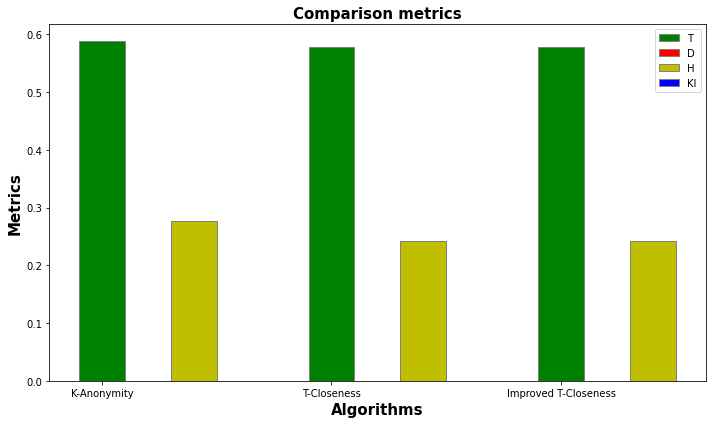

In [48]:
labels = ['K-Anonymity',  'T-Closeness','Improved T-Closeness']


x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots(figsize =(10, 6))

# set height of bar
T= [k_t,t_t,IT_t]
D=[k_d,t_d,IT_d]
H=[k_h,t_h,IT_h]
Kl=[k_kl,t_kl,IT_kl]

 
# Set position of bar on X axis
br1 = np.arange(len(T))
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]
# Make the plot

plt.bar(br1,T ,color ='g', width = width,
        edgecolor ='grey', label ='T')
plt.bar(br2,D,color ='r', width = width,
        edgecolor ='grey', label ='D')
plt.bar(br3,H,color ='y', width = width,
        edgecolor ='grey', label ='H')
plt.bar(br3,Kl,color='b',width = width,
        edgecolor ='grey', label ='Kl')


# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Algorithms', fontweight ='bold', fontsize = 15)
ax.set_ylabel('Metrics',fontweight ='bold', fontsize = 15)
ax.set_title('Comparison metrics',fontweight ='bold', fontsize = 15)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()